Text(value='Please select signal.', disabled=True)

IntText(value=250, description='fs:')

Select(description='Select .txt File:', options=('European ST-T.txt', 'flat3.txt', 'Short Data ECG.txt'), valu…

Button(description='Select .txt File', style=ButtonStyle())

Output()

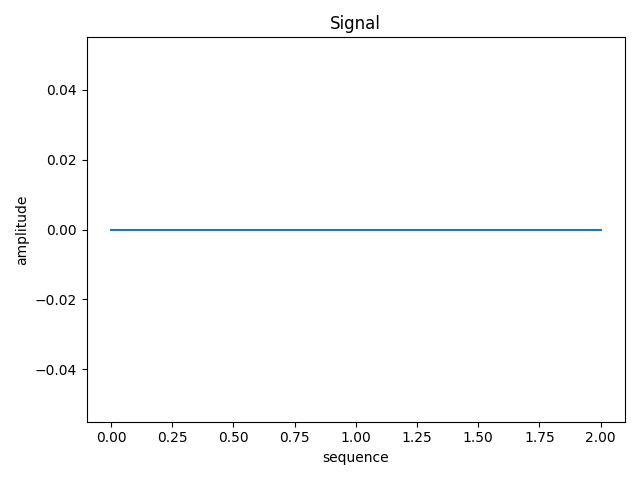

In [1]:
from pathlib import Path
from os import listdir
from os.path import splitext
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from numpy import arange
%matplotlib widget

### Declaration
texts_0 = [[], [], []]

### File Select 
files = listdir(Path().absolute())
temp = []
for file in files:
    if splitext(file)[1] == ".txt":
        temp.append(file)
files_txt = temp

### Widgets File Select
opening_select_signal = widgets.Text(
    value='Please select signal.', 
    disabled=True)
select_frequency_sampling = widgets.IntText(
    value=250,
    description='fs:',
    disabled=False
)
select_txt_file = widgets.Select(
    options=files_txt,
    description='Select .txt File:',
    disabled=False
)
button_select_txt_file = widgets.Button(description='Select .txt File')
def on_button_select_txt_file_clicked(change):
    with out_1:
        with open(select_txt_file.get_interact_value(), "r") as file:
            text_file = file.readlines()
        try:
            temp1 = []
            temp2 = []
            temp3 = []
            for x in text_file:
                temp = x.replace("\n", "")
                temp = temp.split()
                temp1.append(int(temp[0]))
                temp2.append(float(temp[1]))
                temp3.append(float(temp[2]))
                
        except ValueError:
            print("Please select three column data file. File Read Error!")
            return
        texts_0[0] = temp1
        texts_0[1] = temp2
        texts_0[2] = temp3
        print(texts_0)
    
    with out_0:    
        plot_0.set_data(texts_0[0], texts_0[1])
        fig_0_ax.set_xlim([0, max(texts_0[0])])
        fig_0_ax.set_ylim([min(texts_0[1]), max(texts_0[1])])
        # plot_1.set_data(texts_0[0], texts_0[2])
        # fig_0_ax[1].set_xlim([0, max(texts_0[0])])
        # fig_0_ax[1].set_ylim([min(texts_0[2]), max(texts_0[2])])
button_select_txt_file.on_click(on_button_select_txt_file_clicked)

### Widget Outputs
out_0 = widgets.Output()
with out_0:
    try:
        plt.close(fig_0)
    except:
        pass
    fig_0, fig_0_ax = plt.subplots(nrows=1, ncols=1)
    fig_0_ax.set(xlabel="sequence", ylabel="amplitude", title="Signal")
    plot_0, = fig_0_ax.plot([0,1,2], [0,0,0])
    plt.tight_layout()
out_1 = widgets.Output()

### Display
display(opening_select_signal, 
        select_frequency_sampling,
        select_txt_file,
        button_select_txt_file,
        out_0)

In [6]:
class discrete_wavelet_transform:   
    """CWT class, gunakan fungsi dalam class untuk mengakses variable yang ingin di pantau.
    """     
    def __init__(self, raw_data, frequency_sampling):
        import numpy as np
        self.zeros = np.zeros
        self.cos = np.cos
        self.sin = np.sin
        self.pi = np.pi
        self.sqrt = np.sqrt
        self.sqr = lambda x: x**2
        self.data = raw_data
        self.lengthdata = len(raw_data)
        self.fs = frequency_sampling
        self.nfilterbank = 5
        
    def dirac(self, x):
        if x == 0:
            return 1
        else:
            return 0

    def koef_filter_hg(self):  
        """Menemukan koefisien filter h dan g

        Returns
        -------
        array 1d
            koefisien filter g
        array 1d
            koefisien filter h
        """                  
        

        start_increment = -2
        end_increment = 1
        delta_increment = end_increment-start_increment
        
        g = self.zeros(delta_increment) # Base array untuk array isi nol
        h = self.zeros(delta_increment)
        
        for n in range(start_increment, end_increment):
            g[n-start_increment] = -2 * (self.dirac(n) - self.dirac(n+1))
            h[n-start_increment] = 1/8 * (self.dirac(n-1) + 3*self.dirac(n) + 3*self.dirac(n) + self.dirac(n+2))
        return g, h

    def respon_frekuensi_hg(self):
        """Proses koefisien h dan g menjadi respon frekuensi

        Returns
        -------
        array 1d
            respon frekuensi Hw
        array 1d
            respon frekuensi Gw
        """        
        Hw = self.zeros(self.fs) # Base array untuk array isi nol
        Gw = self.zeros(self.fs)
        
        g, h = self.koef_filter_hg()
        for i in range(0, self.fs):
            reH = 0
            imH = 0
            reG = 0
            imG = 0
            start_increment = -1
            end_increment = 2
            for k in range(start_increment, end_increment):
                reG = reG + g[start_increment-k]*self.cos(k*2*self.pi*i/self.fs) # index ditambah agar index tidak negatif
                imG = imG - g[start_increment-k]*self.sin(k*2*self.pi*i/self.fs)
                reH = reH + h[start_increment-k]*self.cos(k*2*self.pi*i/self.fs)
                imH = imH - h[start_increment-k]*self.sin(k*2*self.pi*i/self.fs)
            Hw[i] = self.sqrt(self.sqr(reH) + self.sqr(imH))
            Gw[i] = self.sqrt(self.sqr(reG) + self.sqr(imG))
        return Hw, Gw

    def Qj_w(self):
        """ Fungsi dari filter bank discrete fourier trasform 8 orde

        Returns
        -------
        array 8d
            fungsi filter bank
        """        
        Q = [self.zeros(round(self.fs/2)), 
             self.zeros(round(self.fs/2)), 
             self.zeros(round(self.fs/2)), 
             self.zeros(round(self.fs/2)), 
             self.zeros(round(self.fs/2)), 
             self.zeros(round(self.fs/2)), 
             self.zeros(round(self.fs/2)), 
             self.zeros(round(self.fs/2))]
        Hw, Gw = self.respon_frekuensi_hg() # Gw dan Hw punya panjang array yang sama
        
        for i in range(round(self.fs/2)):
            if (i*128) < len(Gw): # dipakai statement menghindari IndexError saat akses value dari array Gw dan Hw
                Q[0][i] = Gw[i]
                Q[1][i] = Gw[2*i]*Hw[i]
                Q[2][i] = Gw[4*i]*Hw[2*i]*Hw[i]
                Q[3][i] = Gw[8*i]*Hw[4*i]*Hw[2*i]*Hw[i]
                Q[4][i] = Gw[16*i]*Hw[8*i]*Hw[4*i]*Hw[2*i]*Hw[i]
                Q[5][i] = Gw[32*i]*Hw[16*i]*Hw[8*i]*Hw[4*i]*Hw[2*i]*Hw[i]
                Q[6][i] = Gw[64*i]*Hw[32*i]*Hw[16*i]*Hw[8*i]*Hw[4*i]*Hw[2*i]*Hw[i]
                Q[7][i] = Gw[128*i]*Hw[64*i]*Hw[32*i]*Hw[16*i]*Hw[8*i]*Hw[4*i]*Hw[2*i]*Hw[i]
            elif (i*64) < len(Gw):
                Q[0][i] = Gw[i]
                Q[1][i] = Gw[2*i]*Hw[i]
                Q[2][i] = Gw[4*i]*Hw[2*i]*Hw[i]
                Q[3][i] = Gw[8*i]*Hw[4*i]*Hw[2*i]*Hw[i]
                Q[4][i] = Gw[16*i]*Hw[8*i]*Hw[4*i]*Hw[2*i]*Hw[i]
                Q[5][i] = Gw[32*i]*Hw[16*i]*Hw[8*i]*Hw[4*i]*Hw[2*i]*Hw[i]
                Q[6][i] = Gw[64*i]*Hw[32*i]*Hw[16*i]*Hw[8*i]*Hw[4*i]*Hw[2*i]*Hw[i]
            elif (i*32) < len(Gw):
                Q[0][i] = Gw[i]
                Q[1][i] = Gw[2*i]*Hw[i]
                Q[2][i] = Gw[4*i]*Hw[2*i]*Hw[i]
                Q[3][i] = Gw[8*i]*Hw[4*i]*Hw[2*i]*Hw[i]
                Q[4][i] = Gw[16*i]*Hw[8*i]*Hw[4*i]*Hw[2*i]*Hw[i]
                Q[5][i] = Gw[32*i]*Hw[16*i]*Hw[8*i]*Hw[4*i]*Hw[2*i]*Hw[i]
            elif (i*16) < len(Gw):
                Q[0][i] = Gw[i]
                Q[1][i] = Gw[2*i]*Hw[i]
                Q[2][i] = Gw[4*i]*Hw[2*i]*Hw[i]
                Q[3][i] = Gw[8*i]*Hw[4*i]*Hw[2*i]*Hw[i]
                Q[4][i] = Gw[16*i]*Hw[8*i]*Hw[4*i]*Hw[2*i]*Hw[i]
            elif (i*8) < len(Gw):
                Q[0][i] = Gw[i]
                Q[1][i] = Gw[2*i]*Hw[i]
                Q[2][i] = Gw[4*i]*Hw[2*i]*Hw[i]
                Q[3][i] = Gw[8*i]*Hw[4*i]*Hw[2*i]*Hw[i]
            elif (i*4) < len(Gw):
                Q[0][i] = Gw[i]
                Q[1][i] = Gw[2*i]*Hw[i]
                Q[2][i] = Gw[4*i]*Hw[2*i]*Hw[i] 
            elif (i*2) < len(Gw):
                Q[0][i] = Gw[i]
                Q[1][i] = Gw[2*i]*Hw[i]
            elif (i) < len(Gw):
                Q[0][i] = Gw[i]
        return Q

    def Qj_k(self):
        """ Fungsi dari filter bamk discrete fourier transform 5 orde

        Returns
        -------
        array 5d
            fungsi filter bank
        """        
        # kalkulasi array paling panjang
        delta_increment = 0
        temp = 0
        for j in range(0, self.nfilterbank+1): #dikarenakan filter bank dimulai dari satu
            start_increment = -(round(2**j) + round(2**(j-1)) - 2)
            end_increment = -(1 - round(2**(j-1)))
            temp = end_increment-start_increment
            if delta_increment < temp:
                delta_increment = temp
        
        Qj = [self.zeros(delta_increment), 
              self.zeros(delta_increment), 
              self.zeros(delta_increment), 
              self.zeros(delta_increment), 
              self.zeros(delta_increment)]
        
        j = 1
        start_increment = -(round(2**j) + round(2**(j-1)) - 2)
        end_increment = -(1 - round(2**(j-1)))
        delta_increment = abs(end_increment - start_increment) # dipakai selisih agar iterasi bisa mengakses index Array
        for k in range(0, delta_increment):
            Qj[0][k] = -2 * (self.dirac(k)-self.dirac(k+1))
            
        j = 2
        start_increment = -(round(2**j) + round(2**(j-1)) - 2)
        end_increment = -(1 - round(2**(j-1)))
        delta_increment = abs(end_increment - start_increment) # dipakai selisih agar iterasi bisa mengakses index Array
        for k in range(0, delta_increment):
            Qj[1][k] = -1/4 * (self.dirac(k-1) 
                                + 3*self.dirac(k) 
                                + 2*self.dirac(k+1) 
                                - 2*self.dirac(k+2) 
                                - 3*self.dirac(k+3) 
                                - self.dirac(k+4))
        
        j = 3
        start_increment = -(round(2**j) + round(2**(j-1)) - 2)
        end_increment = -(1 - round(2**(j-1)))
        delta_increment = abs(end_increment - start_increment) # dipakai selisih agar iterasi bisa mengakses index Array
        for k in range(0, delta_increment):
            Qj[2][k] = -1/32 * (self.dirac(k-3) 
                                + 3*self.dirac(k-2) 
                                + 6*self.dirac(k-1) 
                                + 10*self.dirac(k) 
                                + 11*self.dirac(k+1)
                                + 9*self.dirac(k+2) 
                                + 4*self.dirac(k+3) 
                                - 4*self.dirac(k+4) 
                                - 9*self.dirac(k+5) 
                                - 11*self.dirac(k+6)
                                - 10*self.dirac(k+7) 
                                - 6*self.dirac(k+8) 
                                - 3*self.dirac(k+9) 
                                - self.dirac(k+10))
        
        j = 4
        start_increment = -(round(2**j) + round(2**(j-1)) - 2)
        end_increment = -(1 - round(2**(j-1)))
        delta_increment = abs(end_increment - start_increment) # dipakai selisih agar iterasi bisa mengakses index Array
        for k in range(0, delta_increment):
            Qj[3][k] = -1/256 * (self.dirac(k-7) 
                                + 3*self.dirac(k-6) 
                                + 6*self.dirac(k-5) 
                                + 10*self.dirac(k-4) 
                                + 15*self.dirac(k-3)
                                + 21*self.dirac(k-2) 
                                + 28*self.dirac(k-1) 
                                + 36*self.dirac(k) 
                                + 41*self.dirac(k+1) 
                                + 43*self.dirac(k+2)
                                + 42*self.dirac(k+3) 
                                + 38*self.dirac(k+4) 
                                + 31*self.dirac(k+5) 
                                + 21*self.dirac(k+6) 
                                + 8*self.dirac(k+7)
                                - 8*self.dirac(k+8) 
                                - 21*self.dirac(k+9) 
                                - 31*self.dirac(k+10) 
                                - 38*self.dirac(k+11) 
                                - 42*self.dirac(k+12)
                                - 43*self.dirac(k+13) 
                                - 41*self.dirac(k+14) 
                                - 36*self.dirac(k+15) 
                                - 28*self.dirac(k+16) 
                                - 21*self.dirac(k+17)
                                - 15*self.dirac(k+18) 
                                - 10*self.dirac(k+19) 
                                - 6*self.dirac(k+20) 
                                - 3*self.dirac(k+21) 
                                - self.dirac(k+22))
            
        j = 5
        start_increment = -(round(2**j) + round(2**(j-1)) - 2)
        end_increment = -(1 - round(2**(j-1)))
        delta_increment = abs(end_increment - start_increment) # dipakai selisih agar iterasi bisa mengakses index Array
        for k in range(0, delta_increment):
            Qj[4][k] = -1/512 * (self.dirac(k-15) 
                                + 3*self.dirac(k-14) 
                                + 6*self.dirac(k-13) 
                                + 10*self.dirac(k-12) 
                                + 15*self.dirac(k-11) 
                                + 21*self.dirac(k-10)
                                + 28*self.dirac(k-9) 
                                + 36*self.dirac(k-8) 
                                + 45*self.dirac(k-7) 
                                + 55*self.dirac(k-6) 
                                + 66*self.dirac(k-5) 
                                + 78*self.dirac(k-4)
                                + 91*self.dirac(k-3) 
                                + 105*self.dirac(k-2) 
                                + 120*self.dirac(k-1) 
                                + 136*self.dirac(k) 
                                + 149*self.dirac(k+1) 
                                + 159*self.dirac(k+2)
                                + 166*self.dirac(k+3) 
                                + 170*self.dirac(k+4) 
                                + 171*self.dirac(k+5) 
                                + 169*self.dirac(k+6) 
                                + 164*self.dirac(k+7) 
                                + 156*self.dirac(k+8)
                                + 145*self.dirac(k+9) 
                                + 131*self.dirac(k+10) 
                                + 114*self.dirac(k+11) 
                                + 94*self.dirac(k+12) 
                                + 71*self.dirac(k+13) 
                                + 45*self.dirac(k+14)
                                + 16*self.dirac(k+15) 
                                - 16*self.dirac(k+16) 
                                - 45*self.dirac(k+17) 
                                - 71*self.dirac(k+18) 
                                - 94*self.dirac(k+19) 
                                - 114*self.dirac(k+20)
                                - 131*self.dirac(k+21) 
                                - 145*self.dirac(k+22) 
                                - 156*self.dirac(k+23) 
                                - 164*self.dirac(k+24) 
                                - 169*self.dirac(k+25)
                                - 171*self.dirac(k+26) 
                                - 170*self.dirac(k+27) 
                                - 166*self.dirac(k+28) 
                                - 159*self.dirac(k+29) 
                                - 149*self.dirac(k+30)
                                - 136*self.dirac(k+31) 
                                - 120*self.dirac(k+32) 
                                - 105*self.dirac(k+33) 
                                - 91*self.dirac(k+34) 
                                - 78*self.dirac(k+35)
                                - 66*self.dirac(k+36) 
                                - 55*self.dirac(k+37) 
                                - 45*self.dirac(k+38) 
                                - 36*self.dirac(k+39) 
                                - 28*self.dirac(k+40)
                                - 21*self.dirac(k+41) 
                                - 15*self.dirac(k+42) 
                                - 10*self.dirac(k+43) 
                                - 6*self.dirac(k+44) 
                                - 3*self.dirac(k+45)
                                - self.dirac(k+46))
        return Qj
    
    def __time(self): # mencari waktu antara filter bank satu dan seterusnya
        """ Fungsi mencari waktu filter bank

        Returns
        -------
        t1
            waktu filter bank pertama
        t2
            waktu filter bank kedua
        t3
            waktu filter bank ketiga
        t4
            waktu filter bank keempat
        t5
            waktu filter bank kelima
        """        
        t1 = round(2**(1-1))
        t2 = round(2**(2-1))
        t3 = round(2**(3-1))
        t4 = round(2**(4-1))
        t5 = round(2**(5-1))
        
        return t1, t2, t3, t4, t5

    def __delay(self): # mencari selisih waktu antara filter bank satu dan yang lain
        """ Fungsi mencari selisih waktu antara waktu filter bank satu dan yang lain

        Returns
        -------
        delay1
            selisih filter bank lima dan filter bank satu
        delay2
            selisih filter bank lima dan filter bank dua
        delay3
            selisih filter bank lima dan filter bank tiga
        delay4
            selisih filter bank lima dan filter bank empat
        delay
            selisih filter bank lima dan filter bank lima
        """        
        t1, t2, t3, t4, t5 = self.__time()
        
        delay1 = t5 - t1
        delay2 = t5 - t2
        delay3 = t5 - t3
        delay4 = t5 - t4
        delay5 = t5 - t5
        
        return delay1, delay2, delay3, delay4, delay5

    def mallat(self):
        """ Fungsi dari algoritma mallat

        Returns
        -------
        array 5d
            wavelet dari algoritma mallat
        array 5d
            scaling dari algoritma mallat
        """        
        w2fm = [self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata)] # base array untuk array isi nol
        s2fm = w2fm
        g, h = self.koef_filter_hg()
        
        for n in range(0, self.lengthdata):
            for j in range(0, self.nfilterbank):
                start_increment = -1
                end_increment = 2
                for k in range(start_increment, end_increment):
                    if (round(n-2**(j)*k) > 0) and (round(n-2**(j)*k) < self.lengthdata): # agar tidak IndexError
                        w2fm[j][n] = w2fm[j][n] + g[k-start_increment]*self.data[round(n-2**(j)*k)] # index disesuaikan
                        s2fm[j][n] = s2fm[j][n] + h[k-start_increment]*self.data[round(n-2**(j)*k)] 
            
        return w2fm, s2fm

    def filter_bank(self):  
              
        Qj = self.Qj_k()
        t1, t2, t3, t4, t5 = self.__time() 
        
        w2fb = [self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata)] # Base array untuk array isi nol
        
        ### FILTERBANK
        for n in range(0, self.lengthdata):
            for j in range(1, self.nfilterbank): # adanya pengurangan di perhitungan start_increment
                start_increment = -(round(2**j) + round(2**(j-1)) - 2)
                end_increment = -(1 - round(2**(j-1)))
                for k in range(start_increment, end_increment):
                    if (n-k) < self.lengthdata: # agar tidak IndexError
                        if (n+t1) < self.lengthdata: 
                            w2fb[0][n + t1] = w2fb[0][n + t1] + Qj[0][k]*self.data[n-k] # perulangan kode biar gampang dibaca
                        if (n+t2) < self.lengthdata:
                            w2fb[1][n + t2] = w2fb[1][n + t2] + Qj[1][k]*self.data[n-k]
                        if (n+t3) < self.lengthdata:
                            w2fb[2][n + t3] = w2fb[2][n + t3] + Qj[2][k]*self.data[n-k]
                        if (n+t4) < self.lengthdata:    
                            w2fb[3][n + t4] = w2fb[3][n + t4] + Qj[3][k]*self.data[n-k]
                        if (n+t5) < self.lengthdata:
                            w2fb[4][n + t5] = w2fb[4][n + t5] + Qj[4][k]*self.data[n-k]
        return w2fb # agar bisa diakses pada function lain dalam class
        
    def filter_bank_peak(self):  
        w2fb = self.filter_bank()
        w2fbmax = self.zeros(self.nfilterbank) # Base array untuk array isi nol
        w2fbmin = self.zeros(self.nfilterbank)
          
        for j in range(0, self.nfilterbank):
            w2fbmax[j] = max(w2fb[j])
            w2fbmin[j] = min(w2fb[j])
        
        return w2fbmax, w2fbmin
    
    def maxima_minima(self):
        gradien = [self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata)]
        result = [self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata)]
        w2fb = self.filter_bank()
              
        for n in range(0, self.lengthdata):
            for j in range(0, self.nfilterbank):
                gradien[j][n] = w2fb[j][n - (j+1)] - w2fb[j][n + (j+1)] # j+1 untuk perulangan gradien satu dan seterusnya
            
            if gradien[0][n] > 0.7:
                result[0][n] = 1
            else:
                result[0][n] = 0

            if gradien[1][n] > 0.7:
                result[1][n] = 1
            else:
                result[1][n] = 0
        
            if gradien[2][n] > 0.7:
                result[2][n] = 1
            else:
                result[2][n] = 0
        
            if gradien[3][n] > 0.1:
                result[3][n] = 1
            else:
                result[3][n] = 0
        
            if gradien[4][n] > 0.7:
                result[4][n] = 1
            else:
                result[4][n] = 0
        
        return gradien, result
    
    def zero_crossing_detection(self):
        zerocross = [self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata)]
        w2fb = self.filter_bank()
   
        for n in range(1, self.lengthdata): # iterasi mulai dari satu agar bisa membandingkan nilai sebelumnya
            if (w2fb[0][n-1] >= 0.3) and (-0.3 >= w2fb[0][n]):
                zerocross[0][n] = 2
            else:
                zerocross[0][n] = 0
                
            if (w2fb[1][n-1] >= 0.1) and (-0.1 >= w2fb[1][n]):
                zerocross[1][n] = 2
            else:
                zerocross[1][n] = 0
                
            if (w2fb[2][n-1] >= 0.1) and (-0.1 >= w2fb[2][n]):
                zerocross[2][n] = 2
            else:
                zerocross[2][n] = 0
                
            if (w2fb[3][n-1] > 0) and (0 > w2fb[3][n]):
                zerocross[3][n] = 1
            else:
                zerocross[3][n] = 0

            if (w2fb[4][n-1] > 0) and (0 > w2fb[4][n]):
                zerocross[4][n] = 2
            else:
                zerocross[4][n] = 0
        return zerocross
    
    def pulse_detection(self):
        _, result = self.maxima_minima() # membuang array gradien
        zerocross = self.zero_crossing_detection()
        
        resultQRS = self.zeros(self.lengthdata) # base array untuk array isi nol
        resultT = self.zeros(self.lengthdata)
        eventR = self.zeros(self.lengthdata)
        eventT = self.zeros(self.lengthdata)
        eventRT = self.zeros(self.lengthdata)
        eventP = self.zeros(self.lengthdata)
        pulseevent = self.zeros(self.lengthdata)
        savevalueP2 = self.zeros(self.lengthdata)
        savevaluePa = self.zeros(self.lengthdata)
        
        flagP = 0
        pointP = 0
        ### DETEKSI PULSE QRS T
        for n in range(0, self.lengthdata):
            resultQRS[n] = result[0][n] or result[1][n] or result[2][n]
            resultT[n] = result[4][n]
        
        ### DETEKSI P        
        for n in range(0, self.lengthdata):
            eventR[n] = zerocross[3][n] and resultQRS[n]
            eventT[n] = zerocross[3][n] and resultT[n]
            eventRT[n] = eventR[n] or eventT[n]
            eventP[n] = zerocross[3][n] ^ eventRT[n]
            pulseevent[n] = eventP[n] or result[3][n]
        
        k = 0
        for n in range(0, self.lengthdata):
            if flagP == 0:
                if pulseevent[n] == 1:
                    k = k + 1
                    if eventP[n] == 1:
                        pointP = 1
                    else:
                        pointP = 2
                else:
                    if pointP == 1:
                        flagP = 1
                    else:
                        flagP = 2
            
            if flagP == 1:
                for i in range(0, k):
                    savevalueP2[n+i-k] = 1
                flagP = 0
                k = 0
            
            if flagP == 2:
                for i in range(0, k):
                    savevalueP2[n+i-k] = 0
                flagP = 0
                k = 0
        for n in range(0, self.lengthdata):
            savevaluePa[n] = pulseevent[n] * savevalueP2[n]
        
    #kurang deteksi P QRS T

    def detection_architecture(self):
        w2fbb = [self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata)]
        w2fbbmav = [self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata)] # moving average dari depan
        w2fbbmavr = [self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata), 
                self.zeros(self.lengthdata)] # moving average dari belakang
        w2fbbmax = self.zeros(self.nfilterbank)
        window = 10
        
        for n in range(0, self.lengthdata):
            for j in range(0, self.nfilterbank):
                w2fbb[j][n] = abs(self.w2fb[j][n])
                
        for n in range(0, self.lengthdata):
            for i in range(0, window):
                if (n-i) < self.lengthdata: # agar tidak IndexError
                    w2fbbmav[0][n] = w2fbbmav[0][n] + w2fbb[0][n-i]/window
        
        for n in range(self.lengthdata, 0, -1): # berjalan dari belakang
            for i in range(0, window):
                if (n+i) < self.lengthdata: 
                    w2fbbmavr[0][n] = w2fbbmavr[0][n] + w2fbb[0][n+i]/window
                
        for j in range(0, self.nfilterbank):
            w2fbbmax[j] = max(w2fbb[j])
                    
    

In [7]:
ecg = discrete_wavelet_transform(texts_0[1], select_frequency_sampling.get_interact_value())

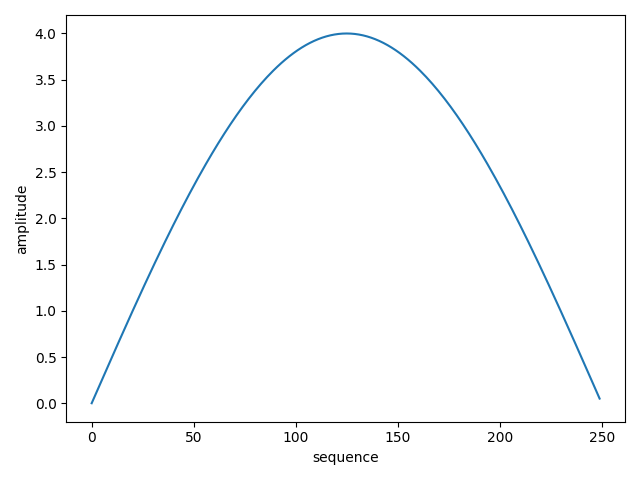

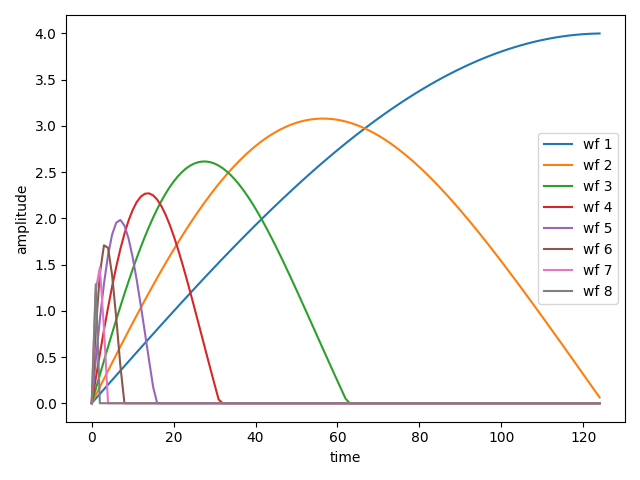

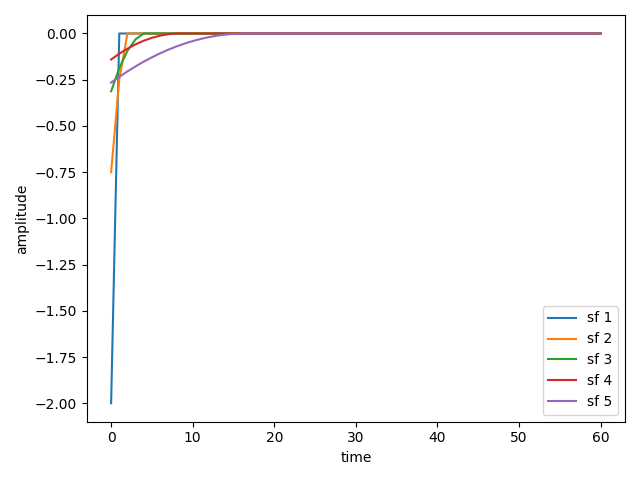

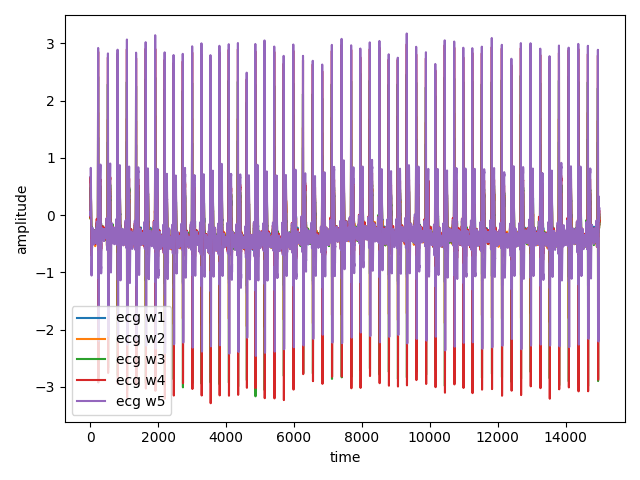

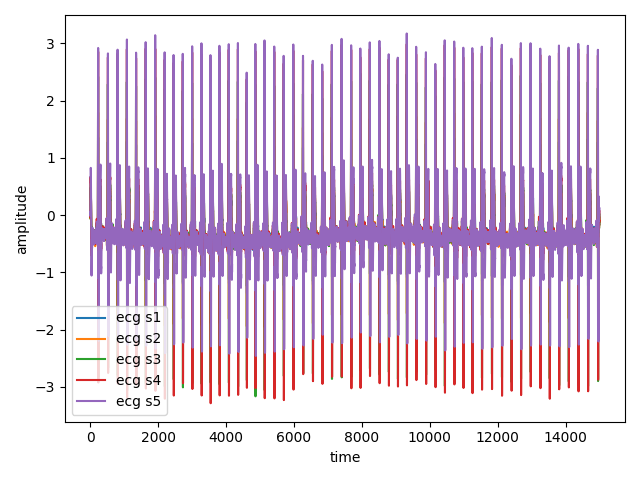

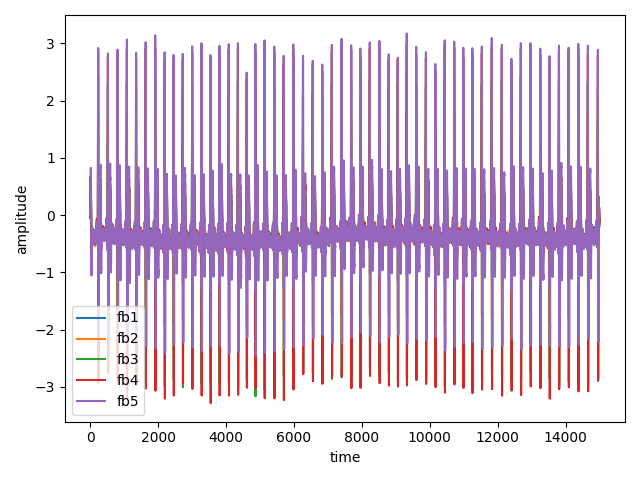

In [8]:
### Declaration
texts_1 = [[], []]

### Print Data
a, b = ecg.koef_filter_hg()
c, d = ecg.respon_frekuensi_hg()
e = ecg.Qj_w() # array 8d
f = ecg.Qj_k() # array 5d
g, h = ecg.mallat() # array 5d
i = ecg.filter_bank() # array 5d

texts_1 = [arange(len(d)), d]

### Widget Outputs
out_1 = widgets.Output()
with out_1:
    try:
        plt.close(fig_1)
    except:
        pass
    fig_1, fig_1_ax = plt.subplots(nrows=1, ncols=1)
    fig_1_ax.set(xlabel="sequence", ylabel="amplitude")
    plot_1, = fig_1_ax.plot(texts_1[0], texts_1[1])
    plt.tight_layout()

out_2 = widgets.Output()
with out_2:
    try:
        plt.close(fig_2)
    except:
        pass
    fig_2, fig_2_ax = plt.subplots(nrows=1, ncols=1)
    fig_2_ax.set(xlabel="time", ylabel="amplitude")
    plot_2, = fig_2_ax.plot(arange(len(e[0])), e[0], label="wf 1")
    plot_3, = fig_2_ax.plot(arange(len(e[1])), e[1], label="wf 2")
    plot_4, = fig_2_ax.plot(arange(len(e[2])), e[2], label="wf 3")
    plot_5, = fig_2_ax.plot(arange(len(e[3])), e[3], label="wf 4")
    plot_6, = fig_2_ax.plot(arange(len(e[4])), e[4], label="wf 5")
    plot_7, = fig_2_ax.plot(arange(len(e[5])), e[5], label="wf 6")
    plot_8, = fig_2_ax.plot(arange(len(e[6])), e[6], label="wf 7")
    plot_9, = fig_2_ax.plot(arange(len(e[7])), e[7], label="wf 8")
    plt.tight_layout()
    plt.legend()

out_3 = widgets.Output()
with out_3:
    try:
        plt.close(fig_3)
    except:
        pass
    fig_3, fig_3_ax = plt.subplots(nrows=1, ncols=1)
    fig_3_ax.set(xlabel="time", ylabel="amplitude")
    plot_10, = fig_3_ax.plot(arange(len(f[0])), f[0], label="sf 1")
    plot_11, = fig_3_ax.plot(arange(len(f[1])), f[1], label="sf 2")
    plot_12, = fig_3_ax.plot(arange(len(f[2])), f[2], label="sf 3")
    plot_13, = fig_3_ax.plot(arange(len(f[3])), f[3], label="sf 4")
    plot_14, = fig_3_ax.plot(arange(len(f[4])), f[4], label="sf 5")
    plt.tight_layout()
    plt.legend()
    
out_4 = widgets.Output()
with out_4:
    try:
        plt.close(fig_4)
    except:
        pass
    fig_4, fig_4_ax = plt.subplots(nrows=1, ncols=1)
    fig_4_ax.set(xlabel="time", ylabel="amplitude")
    plot_15, = fig_4_ax.plot(arange(len(g[0])), g[0], label="ecg w1")
    plot_16, = fig_4_ax.plot(arange(len(g[1])), g[1], label="ecg w2")
    plot_17, = fig_4_ax.plot(arange(len(g[2])), g[2], label="ecg w3")
    plot_18, = fig_4_ax.plot(arange(len(g[3])), g[3], label="ecg w4")
    plot_19, = fig_4_ax.plot(arange(len(g[4])), g[4], label="ecg w5")
    plt.tight_layout()
    plt.legend()
    
out_5 = widgets.Output()
with out_5:
    try:
        plt.close(fig_5)
    except:
        pass
    fig_5, fig_5_ax = plt.subplots(nrows=1, ncols=1)
    fig_5_ax.set(xlabel="time", ylabel="amplitude")
    plot_20, = fig_5_ax.plot(arange(len(h[0])), h[0], label="ecg s1")
    plot_21, = fig_5_ax.plot(arange(len(h[1])), h[1], label="ecg s2")
    plot_22, = fig_5_ax.plot(arange(len(h[2])), h[2], label="ecg s3")
    plot_23, = fig_5_ax.plot(arange(len(h[3])), h[3], label="ecg s4")
    plot_24, = fig_5_ax.plot(arange(len(h[4])), h[4], label="ecg s5")
    plt.tight_layout()
    plt.legend()
    
out_6 = widgets.Output()
with out_6:
    try:
        plt.close(fig_6)
    except:
        pass
    fig_6, fig_6_ax = plt.subplots(nrows=1, ncols=1)
    fig_6_ax.set(xlabel="time", ylabel="amplitude")
    plot_25, = fig_6_ax.plot(arange(len(h[0])), h[0], label="fb1")
    plot_26, = fig_6_ax.plot(arange(len(h[1])), h[1], label="fb2")
    plot_27, = fig_6_ax.plot(arange(len(h[2])), h[2], label="fb3")
    plot_28, = fig_6_ax.plot(arange(len(h[3])), h[3], label="fb4")
    plot_29, = fig_6_ax.plot(arange(len(h[4])), h[4], label="fb5")
    plt.tight_layout()
    plt.legend()